In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

RDKit WARNING: [17:52:41] Enabling RDKit 2019.09.3 jupyter extensions
[17:52:41] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score


In [3]:
# from rdkit.Chem import rdMolDescriptors, MolSurf
# from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

number of all smiles:  1427


number of successfully processed smiles:  1427


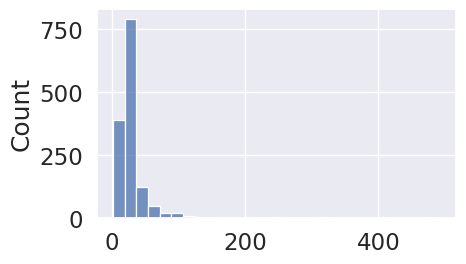

In [4]:
task_name = 'sider'
tasks = [
'SIDER1','SIDER2','SIDER3','SIDER4','SIDER5','SIDER6','SIDER7','SIDER8','SIDER9','SIDER10','SIDER11','SIDER12','SIDER13','SIDER14','SIDER15','SIDER16','SIDER17','SIDER18','SIDER19','SIDER20','SIDER21','SIDER22','SIDER23','SIDER24','SIDER25','SIDER26','SIDER27'
]
raw_filename = "../data/sider.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.histplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

# print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [5]:
random_seed = 68
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.5
fingerprint_dim = 200

radius = 3
T = 3
weight_decay = 3 # also known as l2_regularization_lambda
learning_rate = 3.5
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<151]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

N


I


[Ca+2]


C


[Cl-]


[K+]


[Mg+2]


[Na+]


[OH-]


FS(F)(F)(F)(F)F


[Ba+2].[H-].[H-]


[H-].[H-].[Sr+2]


[As]


[Se]


[Li+]


[Ra]


[Li+].[OH-]


[I-].[Na+]


[249Cf].[249Cf].[O-2].[O-2].[O-2]


[As+3].[As+3].[O-2].[O-2].[O-2]


F


[Ga+3]


[Fe]


[La]


[Sm]


[Ag]


[Tc]


[Cr]


[Cu]


[Gd]


[Y]


[Zn]


feature dicts file saved as ../data/sider.pickle


,SIDER1,SIDER2,SIDER3,SIDER4,SIDER5,SIDER6,SIDER7,SIDER8,SIDER9,SIDER10,...,SIDER20,SIDER21,SIDER22,SIDER23,SIDER24,SIDER25,SIDER26,SIDER27,smiles,cano_smiles
5,0,1,0,1,1,1,1,0,1,0,...,1,1,1,0,0,1,1,1,CC[C@H](C)[C@H]1C(=O)N[C@H]2CSSC[C@@H](C(=O)N[...,CC[C@H](C)[C@H](NC(=O)CN)C(=O)N[C@H](C(=O)N[C@...
29,1,1,0,1,1,1,1,1,1,0,...,1,1,1,0,1,1,1,1,CC[C@H](C)[C@@H](C(=O)N[C@@H](CCC(=O)O)C(=O)N[...,CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H]...
41,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,N,N
47,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,1,1,CC[C@H](C)[C@@H](C(=O)N[C@@H](CC1=CC=C(C=C1)O)...,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...
50,0,0,0,1,1,1,1,0,1,1,...,1,1,0,0,0,1,1,1,I,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,1,0,0,0,1,1,1,0,1,0,...,0,1,1,0,0,1,1,0,CC1=CN(C(=O)NC1=O)[C@H]2C[C@@H]([C@H](O2)COP(=...,COCCO[C@H]1[C@@H](O)[C@H](COP(=O)([O-])S[C@H]2...
1392,0,1,0,0,1,1,1,0,1,0,...,1,1,1,0,1,1,1,1,CCC(C)C(C(=O)NC(CCC(=O)N)C(=O)NC(CC(C)C)C(=O)N...,CCC(C)C(NC(=O)C(CCC(=O)O)NC(=O)C(CO)NC(=O)C(NC...
1393,0,1,0,1,1,1,1,1,1,0,...,1,1,1,0,1,1,1,1,CC1C(=O)NC(C(=O)NC2CSSCC3C(=O)NC(C(=O)NC(C(=O)...,CSCCC1NC(=O)C(CC(C)C)NC(=O)C(CCCNC(=N)N)NC(=O)...
1396,0,1,0,0,1,1,1,0,1,0,...,1,1,1,0,0,0,1,1,CC[C@H](C)[C@H]1C(=O)N[C@H](C(=O)NCC(=O)N[C@H]...,CC[C@H](C)[C@@H]1NC(=O)[C@@H]2CSSC[C@H](NC(=O)...


In [7]:
weights = []
for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])

test_df = remained_df.sample(frac=1/10, random_state=3) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=3) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [8]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features, num_bond_features, fingerprint_dim, output_units_num, p_dropout)
model.cuda()
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

1156058
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
GRUCell.2.weight_ih torch.Size([600, 200])
GRUCell.2.weight_hh torch.Size([600, 200])
GRUCell.2.bias_ih torch.Size([600])
GRUCell.2.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 400])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
attend.2.weight torch.Size([200, 200]

In [9]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        optimizer.zero_grad()
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
                
    eval_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
#     eval_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     eval_precision = [precision_score(y_val_list[i],
#                                      (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
#     eval_recall = [recall_score(y_val_list[i],
#                                (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    eval_loss = np.array(losses_list).mean()
    
    return eval_roc, eval_loss #eval_prc, eval_precision, eval_recall, 


In [10]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_loss = eval(model, train_df)
    valid_roc, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.62:
             torch.save(model.state_dict(), 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
#         +"train_roc"+":"+str(train_roc)+'\n'\
#         +"valid_roc"+":"+str(valid_roc)+'\n'\
        +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
        +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >18) and (epoch - best_param["loss_epoch"] >28):        
        break
        
    train(model, train_df, optimizer, loss_function)


EPOCH:	0
train_roc_mean:0.501387136100516
valid_roc_mean:0.5035495884992728



EPOCH:	1
train_roc_mean:0.5596987910889631
valid_roc_mean:0.5369595768784726



EPOCH:	2
train_roc_mean:0.5613062566110406
valid_roc_mean:0.5378669480859778



EPOCH:	3
train_roc_mean:0.5759327976637141
valid_roc_mean:0.5364218184893683



EPOCH:	4
train_roc_mean:0.5840139634039975
valid_roc_mean:0.5529268130033891



EPOCH:	5
train_roc_mean:0.5934022342425095
valid_roc_mean:0.5534356926502182



EPOCH:	6
train_roc_mean:0.5911020275796032
valid_roc_mean:0.5513840054718914



EPOCH:	7
train_roc_mean:0.5915002808456371
valid_roc_mean:0.5514568291041984



EPOCH:	8
train_roc_mean:0.5919616693823223
valid_roc_mean:0.5569802208600626



EPOCH:	9
train_roc_mean:0.5968775220044902
valid_roc_mean:0.5528953706860569



EPOCH:	10
train_roc_mean:0.599586263089619
valid_roc_mean:0.5510576406874854



EPOCH:	11
train_roc_mean:0.6033447165122715
valid_roc_mean:0.5576633192581318



EPOCH:	12
train_roc_mean:0.6080842713796868
valid_roc_mean:0.5446474002023746



EPOCH:	13
train_roc_mean:0.611076092225282
valid_roc_mean:0.5497794242916685



EPOCH:	14
train_roc_mean:0.6155281123386837
valid_roc_mean:0.5559362132485149



EPOCH:	15
train_roc_mean:0.6215692539323362
valid_roc_mean:0.5490617844595772



EPOCH:	16
train_roc_mean:0.6277139936182301
valid_roc_mean:0.5452968095570945



EPOCH:	17
train_roc_mean:0.631237671320792
valid_roc_mean:0.5522774628455144



EPOCH:	18
train_roc_mean:0.6376154541626365
valid_roc_mean:0.5496307965936608



EPOCH:	19
train_roc_mean:0.6395478765047694
valid_roc_mean:0.5468302888808508



EPOCH:	20
train_roc_mean:0.6488833388279853
valid_roc_mean:0.5455137521918068



EPOCH:	21
train_roc_mean:0.6547786900898884
valid_roc_mean:0.5559966580182225



EPOCH:	22
train_roc_mean:0.658433687231936
valid_roc_mean:0.5421046732118638



EPOCH:	23
train_roc_mean:0.6627805958041405
valid_roc_mean:0.5474534638105583



EPOCH:	24
train_roc_mean:0.6629365749124773
valid_roc_mean:0.5412706358946427



EPOCH:	25
train_roc_mean:0.6636875699563378
valid_roc_mean:0.5468887624393799



EPOCH:	26
train_roc_mean:0.6694893045188399
valid_roc_mean:0.5465386187904441



EPOCH:	27
train_roc_mean:0.6735758042295971
valid_roc_mean:0.5466717274202944



EPOCH:	28
train_roc_mean:0.6771787564170352
valid_roc_mean:0.5519095357098073



EPOCH:	29
train_roc_mean:0.6782038684280421
valid_roc_mean:0.5549685374667919



EPOCH:	30
train_roc_mean:0.6838686250321968
valid_roc_mean:0.5530287127504596



EPOCH:	31
train_roc_mean:0.6841534566443307
valid_roc_mean:0.5521251776838146



EPOCH:	32
train_roc_mean:0.6890454469436434
valid_roc_mean:0.5591262636521035



EPOCH:	33
train_roc_mean:0.6903225623246539
valid_roc_mean:0.5515246665283473



EPOCH:	34
train_roc_mean:0.6943963773440123
valid_roc_mean:0.5627531143577522



EPOCH:	35
train_roc_mean:0.6991504230539277
valid_roc_mean:0.5614368729854954



EPOCH:	36
train_roc_mean:0.6995196568073633
valid_roc_mean:0.5498956404368248



EPOCH:	37
train_roc_mean:0.7001104803351836
valid_roc_mean:0.5653468983602318



EPOCH:	38
train_roc_mean:0.7044085325901702
valid_roc_mean:0.5616542120108963



EPOCH:	39
train_roc_mean:0.7063712321560238
valid_roc_mean:0.5609775638386819



EPOCH:	40
train_roc_mean:0.7105697003175508
valid_roc_mean:0.5619484358861013



EPOCH:	41
train_roc_mean:0.7121092931533671
valid_roc_mean:0.5684622647261258



EPOCH:	42
train_roc_mean:0.7137818808878963
valid_roc_mean:0.5689119330990591



EPOCH:	43
train_roc_mean:0.7174981272949489
valid_roc_mean:0.5624415377769767



EPOCH:	44
train_roc_mean:0.7181947270188133
valid_roc_mean:0.5582506600131095



EPOCH:	45
train_roc_mean:0.7188247497136508
valid_roc_mean:0.570500782962486



EPOCH:	46
train_roc_mean:0.7225508842481522
valid_roc_mean:0.5693295021198888



EPOCH:	47
train_roc_mean:0.7262637222253147
valid_roc_mean:0.5667030499266305



EPOCH:	48
train_roc_mean:0.7296693998426782
valid_roc_mean:0.5672568757915629



EPOCH:	49
train_roc_mean:0.7280251273391758
valid_roc_mean:0.5752938120372294



EPOCH:	50
train_roc_mean:0.7331318442463081
valid_roc_mean:0.5769574200279614



EPOCH:	51
train_roc_mean:0.7349887860997545
valid_roc_mean:0.5699562612756041



EPOCH:	52
train_roc_mean:0.7357075722186468
valid_roc_mean:0.5811888530969656



EPOCH:	53
train_roc_mean:0.7395966566651822
valid_roc_mean:0.5688921382163693



EPOCH:	54
train_roc_mean:0.7434778888109372
valid_roc_mean:0.5758036587932106



EPOCH:	55
train_roc_mean:0.7469845902958048
valid_roc_mean:0.5807975274166163



EPOCH:	56
train_roc_mean:0.7487943126940354
valid_roc_mean:0.5760271617821546



EPOCH:	57
train_roc_mean:0.7486428277126104
valid_roc_mean:0.5818618429285961



EPOCH:	58
train_roc_mean:0.7521696268900846
valid_roc_mean:0.5794264854025835



EPOCH:	59
train_roc_mean:0.7524948258400183
valid_roc_mean:0.5794022102123023



EPOCH:	60
train_roc_mean:0.7561404947115754
valid_roc_mean:0.58593470118906



EPOCH:	61
train_roc_mean:0.7596119474559055
valid_roc_mean:0.5928648670983931



EPOCH:	62
train_roc_mean:0.7613776769233701
valid_roc_mean:0.5814803881144142



EPOCH:	63
train_roc_mean:0.7621031839975551
valid_roc_mean:0.5863148244864982



EPOCH:	64
train_roc_mean:0.7641896491269506
valid_roc_mean:0.5919665643730798



EPOCH:	65
train_roc_mean:0.7639502993397189
valid_roc_mean:0.5870305931958493



EPOCH:	66
train_roc_mean:0.7677185542086683
valid_roc_mean:0.5922838860427768



EPOCH:	67
train_roc_mean:0.7697447202500136
valid_roc_mean:0.5849478474818537



EPOCH:	68
train_roc_mean:0.7709176873306318
valid_roc_mean:0.5949782475007573



EPOCH:	69
train_roc_mean:0.7768500612491456
valid_roc_mean:0.5901777195174408



EPOCH:	70
train_roc_mean:0.7792251640643111
valid_roc_mean:0.6002349290226123



EPOCH:	71
train_roc_mean:0.7795955263453762
valid_roc_mean:0.590490179854905



EPOCH:	72
train_roc_mean:0.7835602361466621
valid_roc_mean:0.5981080267294332



EPOCH:	73
train_roc_mean:0.7843031307069283
valid_roc_mean:0.5846448337454054



EPOCH:	74
train_roc_mean:0.7806250041848102
valid_roc_mean:0.5971886749161004



EPOCH:	75
train_roc_mean:0.7885454829811595
valid_roc_mean:0.5954396504931698



EPOCH:	76
train_roc_mean:0.7907493677576501
valid_roc_mean:0.5994995576191864



EPOCH:	77
train_roc_mean:0.7937890791149216
valid_roc_mean:0.5920993949609107



EPOCH:	78
train_roc_mean:0.7967049343750618
valid_roc_mean:0.5921200273840663



EPOCH:	79
train_roc_mean:0.797297955173516
valid_roc_mean:0.5881880847206268



EPOCH:	80
train_roc_mean:0.7984856532514014
valid_roc_mean:0.6008788285214938



EPOCH:	81
train_roc_mean:0.7992025763562929
valid_roc_mean:0.6070302608435534



EPOCH:	82
train_roc_mean:0.8048665190489745
valid_roc_mean:0.5978917093790679



EPOCH:	83
train_roc_mean:0.8083520616146034
valid_roc_mean:0.5959908029392195



EPOCH:	84
train_roc_mean:0.811230549370006
valid_roc_mean:0.6073904869513924



EPOCH:	85
train_roc_mean:0.8097741197583642
valid_roc_mean:0.6048127384921038



EPOCH:	86
train_roc_mean:0.8153353619399352
valid_roc_mean:0.5989302444754552



EPOCH:	87
train_roc_mean:0.8143271429625547
valid_roc_mean:0.6113660426611124



EPOCH:	88
train_roc_mean:0.8150905860230566
valid_roc_mean:0.594736656735095



EPOCH:	89
train_roc_mean:0.8180603979138108
valid_roc_mean:0.603118177727752



EPOCH:	90
train_roc_mean:0.8147722635956279
valid_roc_mean:0.5946228542396129



EPOCH:	91
train_roc_mean:0.8210412645974464
valid_roc_mean:0.6104501914638857



EPOCH:	92
train_roc_mean:0.8225514403911633
valid_roc_mean:0.6050731719826169



EPOCH:	93
train_roc_mean:0.8175042641138054
valid_roc_mean:0.6102633256542163



EPOCH:	94
train_roc_mean:0.8224272659509594
valid_roc_mean:0.6126853466420852



EPOCH:	95
train_roc_mean:0.8299555897553371
valid_roc_mean:0.6089845713831823



EPOCH:	96
train_roc_mean:0.8313920968192795
valid_roc_mean:0.6140122074080083



EPOCH:	97
train_roc_mean:0.8326621272725787
valid_roc_mean:0.6142170789356954



EPOCH:	98
train_roc_mean:0.8397586977893802
valid_roc_mean:0.6073415419854631



EPOCH:	99
train_roc_mean:0.8408362018917822
valid_roc_mean:0.6070587818056752



EPOCH:	100
train_roc_mean:0.8407340358853027
valid_roc_mean:0.6166819180398966



EPOCH:	101
train_roc_mean:0.8435735758380253
valid_roc_mean:0.6175477398120229



EPOCH:	102
train_roc_mean:0.8426308737032784
valid_roc_mean:0.6227364233563343



EPOCH:	103
train_roc_mean:0.8458933827723064
valid_roc_mean:0.6071857951327052



EPOCH:	104
train_roc_mean:0.8436607207995304
valid_roc_mean:0.6207807282931636



EPOCH:	105
train_roc_mean:0.8513311441647673
valid_roc_mean:0.6185900638104214



EPOCH:	106
train_roc_mean:0.8525360681364333
valid_roc_mean:0.6254420668997696



EPOCH:	107
train_roc_mean:0.8491402710490275
valid_roc_mean:0.6407221563766597



EPOCH:	108
train_roc_mean:0.8558921044454041
valid_roc_mean:0.6152554000352445



EPOCH:	109
train_roc_mean:0.8585464179659231
valid_roc_mean:0.6353753095351586



EPOCH:	110
train_roc_mean:0.8628264860161947
valid_roc_mean:0.6116981817260452



EPOCH:	111
train_roc_mean:0.8615742515798367
valid_roc_mean:0.6261636199316181



EPOCH:	112
train_roc_mean:0.8646079100041398
valid_roc_mean:0.6274423912887713



EPOCH:	113
train_roc_mean:0.8664064413208271
valid_roc_mean:0.6221421042309175



EPOCH:	114
train_roc_mean:0.866892018839881
valid_roc_mean:0.6105516209035079



EPOCH:	115
train_roc_mean:0.8671710695816034
valid_roc_mean:0.6107043038613859



EPOCH:	116
train_roc_mean:0.8726963297154193
valid_roc_mean:0.6268495330130199



EPOCH:	117
train_roc_mean:0.8726274404592713
valid_roc_mean:0.6196740116620484



EPOCH:	118
train_roc_mean:0.875918735469523
valid_roc_mean:0.6263123687812788



EPOCH:	119
train_roc_mean:0.8749945928776407
valid_roc_mean:0.6174958183645581



EPOCH:	120
train_roc_mean:0.8812170445645078
valid_roc_mean:0.623036266460082



EPOCH:	121
train_roc_mean:0.8799361106749607
valid_roc_mean:0.6149879499374064



EPOCH:	122
train_roc_mean:0.87905149543403
valid_roc_mean:0.6165616668828013



EPOCH:	123
train_roc_mean:0.8802835997883671
valid_roc_mean:0.6347840674390208



EPOCH:	124
train_roc_mean:0.8868315686395177
valid_roc_mean:0.6262409082557059



EPOCH:	125
train_roc_mean:0.8905615530374168
valid_roc_mean:0.6285556768412849



EPOCH:	126
train_roc_mean:0.8878010074253005
valid_roc_mean:0.6205336618999526



In [11]:
# evaluate model
best_model = Fingerprint(radius, T, num_atom_features, num_bond_features, fingerprint_dim, output_units_num, p_dropout)
best_model_state_dict = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')
best_model.load_state_dict(best_model_state_dict)     
best_model.cuda()

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_roc, test_losses = eval(model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )

best epoch:107
test_roc:[0.6297726297726298, 0.6023391812865496, 0.46766169154228854, 0.646236559139785, 0.620940170940171, 0.4896907216494846, 0.6759999999999999, 0.6624649859943978, 0.6078571428571429, 0.6489769820971867, 0.6919691969196919, 0.6724565756823822, 0.6465696465696466, 0.6953612845673506, 0.6157817109144542, 0.7289855072463768, 0.597394540942928, 0.604642857142857, 0.6718921892189218, 0.5018918918918919, 0.5761381475667191, 0.6632855022266204, 0.6544011544011544, 0.5715811965811965, 0.6055718475073314, 0.7533333333333332, 0.5099424385138671]
test_roc_mean: 0.6227088550557911
